<a href="https://colab.research.google.com/github/Susmit-A/EIP/blob/master/p2a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
import numpy as np

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath="model.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [6]:
model = resnet_v1(input_shape=(32, 32, 3), depth=20, num_classes=10)
model.compile("rmsprop", "categorical_crossentropy", metrics=['accuracy'])

W0629 15:49:52.936455 139787576711040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 15:49:52.960358 139787576711040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 15:49:52.966073 139787576711040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0629 15:49:52.995045 139787576711040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0629 15:49:52.997331

In [7]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=5,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.01,
        # set range for random zoom
        zoom_range=0.01,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format="channels_last",
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0
)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=2048),
                    validation_data=(x_test, y_test),
                    steps_per_epoch=int(50000/2048)+1,
                    epochs=50,
                    callbacks=callbacks)

Using real-time data augmentation.


W0629 15:49:57.406512 139787576711040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate:  0.001
25/25 [==============================] - 27s 1s/step - loss: 2.1733 - acc: 0.2937 - val_loss: 1.8607 - val_acc: 0.3640

Epoch 00001: val_acc improved from -inf to 0.36400, saving model to model.h5
Epoch 2/50
Learning rate:  0.001
25/25 [==============================] - 18s 729ms/step - loss: 1.7529 - acc: 0.4027 - val_loss: 2.3198 - val_acc: 0.2990

Epoch 00002: val_acc did not improve from 0.36400
Epoch 3/50
Learning rate:  0.001
25/25 [==============================] - 22s 880ms/step - loss: 1.6338 - acc: 0.4537 - val_loss: 1.9154 - val_acc: 0.3822

Epoch 00003: val_acc improved from 0.36400 to 0.38220, saving model to model.h5
Epoch 4/50
Learning rate:  0.001
25/25 [==============================] - 22s 869ms/step - loss: 1.5663 - acc: 0.4794 - val_loss: 1.6512 - val_acc: 0.4560

Epoch 00004: val_acc improved from 0.38220 to 0.45600, saving model to model.h5
Epoch 5/50
Learning rate:  0.001
25/25 [==============================] - 21s 860ms/step - l

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
import io
import cv2
import numpy as np
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [33]:
from google.colab.patches import cv2_imshow

model.load_weights("model.h5")

mcount = 0
misclass = np.empty((100, 32, 32, 3), dtype=np.float32)

for i in range(np.shape(x_test)[0]):
    out = np.argmax(np.squeeze(model.predict(np.expand_dims(x_test[i], axis=0))))
    y = np.argmax(y_test[i])
    if out != y:
        print("Actual: ", y, "\tPredicted: ", out, "\tImage: ", i)
        last_conv_layer = model.get_layer("conv2d_21")
        class_output = model.output[:, out]
        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(x_test[i], axis=0)])
        for j in range(64):
            conv_layer_output_value[:, :, j] *= pooled_grads_value[j]
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        heatmap = cv2.resize(heatmap, (32, 32))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(cv2.resize(x_test[i], (32, 32)), 0.6, heatmap, 0.4, 0)
        # showarray(cv2.resize(x_test[i], (32, 32)))
        # showarray(superimposed_img)
        misclass[mcount, :, :, :] = x_test[i]
        misclass[mcount+1, :, :, :] = superimposed_img
        mcount += 2
        if mcount==100:
            break

Actual:  0 	Predicted:  8 	Image:  3
Actual:  6 	Predicted:  2 	Image:  7
Actual:  3 	Predicted:  4 	Image:  8
Actual:  5 	Predicted:  4 	Image:  12
Actual:  5 	Predicted:  4 	Image:  24
Actual:  2 	Predicted:  9 	Image:  25
Actual:  4 	Predicted:  2 	Image:  32
Actual:  5 	Predicted:  8 	Image:  33
Actual:  2 	Predicted:  8 	Image:  35
Actual:  4 	Predicted:  7 	Image:  36
Actual:  1 	Predicted:  9 	Image:  37
Actual:  3 	Predicted:  6 	Image:  46
Actual:  0 	Predicted:  7 	Image:  52
Actual:  3 	Predicted:  6 	Image:  53
Actual:  7 	Predicted:  3 	Image:  57
Actual:  4 	Predicted:  3 	Image:  58
Actual:  3 	Predicted:  5 	Image:  61
Actual:  3 	Predicted:  9 	Image:  63
Actual:  1 	Predicted:  8 	Image:  66
Actual:  6 	Predicted:  3 	Image:  71
Actual:  9 	Predicted:  0 	Image:  76
Actual:  3 	Predicted:  5 	Image:  78
Actual:  1 	Predicted:  8 	Image:  81
Actual:  2 	Predicted:  5 	Image:  84
Actual:  5 	Predicted:  7 	Image:  85
Actual:  2 	Predicted:  7 	Image:  86
Actual:  7 	Pre

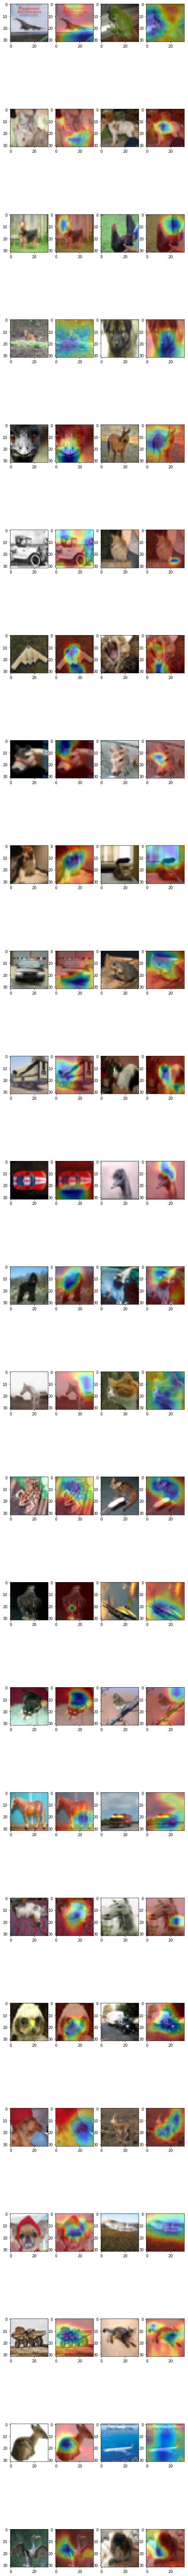

In [66]:
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(128, 128))
columns = 4
rows = 25
for i in range(1, 101):
    img = misclass[i-1] / 255
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.subplots_adjust(left=0.0, bottom=None, right=0.05, top=None, wspace=0.2, hspace=0)
plt.show()